# Deep Q-Learning on Atari: Pong (Double DQN)

Obs: (4, 84, 84) stacked grayscale  
Actions: 6 discrete (ALE)  
Rewards: sparse ±1 per point  

This version applies Double DQN to the same Pong environment.  
The model uses the online network to select the next action and the target network to evaluate it, reducing Q-value overestimation compared to the baseline.

## Install & register Atari

In [ ]:
## Install & register Atari

import os, sys, subprocess, importlib, pathlib

def _need(mod):
    try:
        importlib.import_module(mod); return False
    except Exception:
        return True

# Core packages
if _need("gymnasium"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gymnasium[atari,accept-rom-license]"])
if _need("ale_py"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ale-py"])

# AutoROM for ROM setup
if _need("autorom") and _need("AutoROM"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "autorom", "AutoROM.accept-rom-license"])

rom_dir = pathlib.Path.home() / ".atari_roms"
rom_dir.mkdir(parents=True, exist_ok=True)
os.environ["ALE_ROM_DIR"] = str(rom_dir)

# Try multiple entry points; continue if already installed
last_err = None
for entry in (["-m", "AutoROM"], ["-m", "autorom"]):
    try:
        subprocess.check_call([sys.executable, *entry, "--accept-license", "--install-dir", str(rom_dir)])
        last_err = None
        break
    except Exception as e:
        last_err = e
if last_err:
    print("ROM install: skipped or already configured.")

# Quick check (non-fatal)
import gymnasium as gym
try:
    env = gym.make("ALE/Pong-v5")
    env.reset(); env.close()
    print("Atari env ready.")
except Exception as e:
    print("Atari check warning:", e)

ROM install: skipped or already configured.
Atari env ready.


## Imports & Global Configuration

In [ ]:
import os, random, collections
from typing import Tuple, Optional
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym

def _resolve_wrappers():
    g = globals()
    # Try unified import
    try:
        from gymnasium.wrappers import (
            AtariPreprocessing as _AP,
            GrayScaleObservation as _GSO,
            TransformObservation as _TO,
            RecordVideo as _RV,
            FrameStack as _FS,
        )
        g.setdefault("AtariPreprocessing", _AP)
        g.setdefault("GrayScaleObservation", _GSO)
        g.setdefault("TransformObservation", _TO)
        g.setdefault("RecordVideo", _RV)
        g.setdefault("FrameStack", _FS)
    except Exception:
        pass

    # Try split-module paths
    if "AtariPreprocessing" not in g:
        try:
            from gymnasium.wrappers.atari_preprocessing import AtariPreprocessing as _AP
            g["AtariPreprocessing"] = _AP
        except Exception:
            pass
    if "GrayScaleObservation" not in g:
        try:
            from gymnasium.wrappers.gray_scale_observation import GrayScaleObservation as _GSO
            g["GrayScaleObservation"] = _GSO
        except Exception:
            pass
    if "TransformObservation" not in g:
        try:
            from gymnasium.wrappers.transform_observation import TransformObservation as _TO
            g["TransformObservation"] = _TO
        except Exception:
            pass
    if "RecordVideo" not in g:
        try:
            from gymnasium.wrappers.record_video import RecordVideo as _RV
            g["RecordVideo"] = _RV
        except Exception:
            pass
    if "FrameStack" not in g:
        try:
            from gymnasium.wrappers.frame_stack import FrameStack as _FS
            g["FrameStack"] = _FS
        except Exception:
            pass

    # Minimal fallbacks
    if "FrameStack" not in g:
        from collections import deque
        class FrameStack(gym.Wrapper):
            def __init__(self, env, num_stack: int = 4):
                super().__init__(env)
                self.num_stack = num_stack
                self.frames = deque(maxlen=num_stack)
                obs, _ = env.reset(seed=42)
                obs = np.array(obs)
                if obs.ndim == 2:
                    obs = obs[None, ...]
                C, H, W = obs.shape
                self.observation_space = gym.spaces.Box(low=0, high=255, shape=(C*num_stack, H, W), dtype=np.uint8)
            def reset(self, **kwargs):
                obs, info = self.env.reset(**kwargs)
                obs = np.array(obs)
                if obs.ndim == 2:
                    obs = obs[None, ...]
                for _ in range(self.num_stack):
                    self.frames.append(obs)
                return self._obs(), info
            def step(self, action):
                obs, r, term, trunc, info = self.env.step(action)
                obs = np.array(obs)
                if obs.ndim == 2:
                    obs = obs[None, ...]
                self.frames.append(obs)
                return self._obs(), r, term, trunc, info
            def _obs(self):
                return np.concatenate(list(self.frames), axis=0).astype(np.uint8)
        g["FrameStack"] = FrameStack

    if "RecordVideo" not in g:
        class RecordVideo(gym.Wrapper):
            def __init__(self, env, *args, **kwargs):
                super().__init__(env)
        g["RecordVideo"] = RecordVideo

_resolve_wrappers()

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Hyperparameters
ENV_ID = "ALE/Pong-v5"
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 32
REPLAY_SIZE = 100_000
REPLAY_START_SIZE = 50_000
TARGET_SYNC_EVERY = 10_000
EPS_START, EPS_END, EPS_DECAY_STEPS = 1.0, 0.05, 500_000
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

Device: cuda


## Environment Preprocessing

In [ ]:
import gymnasium as gym
import numpy as np

class ToCHW(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs, _ = env.reset(seed=42)
        obs = np.array(obs)
        if obs.ndim == 2:            # H,W
            C, H, W = 1, *obs.shape
        elif obs.ndim == 3 and obs.shape[-1] == 1:  # H,W,1
            H, W = obs.shape[:2]
            C = 1
        else:
            raise RuntimeError(f"Unexpected obs shape: {obs.shape}")
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(C, H, W), dtype=np.uint8)

    def observation(self, obs):
        obs = np.array(obs)
        if obs.ndim == 2:                    # H,W -> (1,H,W)
            return obs[None, ...]
        elif obs.ndim == 3 and obs.shape[-1] == 1:  # H,W,1 -> (1,H,W)
            return np.transpose(obs, (2, 0, 1))
        return obs

def make_env(env_id: str):
    env = gym.make(env_id, frameskip=4, repeat_action_probability=0.25)
    env = AtariPreprocessing(env, grayscale_obs=True, frame_skip=1, scale_obs=False, screen_size=84)
    env = ToCHW(env)
    env = FrameStack(env, num_stack=4)
    return env

def state_to_tensor(state, device):
    if isinstance(state, tuple):
        state = state[0]
    arr = np.array(state, copy=False)
    if arr.ndim == 3:
        arr = np.expand_dims(arr, 0)
    return torch.from_numpy(arr).to(device).float() / 255.0

## Model (DQN architecture for Double DQN)

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_shape: Tuple[int,int,int], n_actions: int):
        super().__init__()
        c,h,w = input_shape
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Flatten()
        )
        with torch.no_grad():
            feat = self.conv(torch.zeros(1, c, h, w)).shape[-1]
        self.fc = nn.Sequential(
            nn.Linear(feat, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x):
        return self.fc(self.conv(x))

## Replay buffer, batching, and  ε-greedy Agent

In [ ]:
Experience = collections.namedtuple('Experience', field_names=['state','action','reward','done','next_state'])

class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer: list[Experience] = []
        self.capacity = capacity
        self.pos = 0
    def __len__(self): return len(self.buffer)
    def append(self, exp: Experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(exp)
        else:
            self.buffer[self.pos] = exp
        self.pos = (self.pos + 1) % self.capacity
    def sample(self, batch_size: int) -> list[Experience]:
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in idxs]

def batch_to_tensors(batch: list[Experience], device: torch.device):
    states = np.stack([b.state for b in batch], axis=0)
    next_states = np.stack([b.next_state for b in batch], axis=0)
    actions = np.array([b.action for b in batch], dtype=np.int64)
    rewards = np.array([b.reward for b in batch], dtype=np.float32)
    dones = np.array([b.done for b in batch], dtype=np.bool_)
    states_t = torch.from_numpy(states).to(device).float() / 255.0
    next_states_t = torch.from_numpy(next_states).to(device).float() / 255.0
    actions_t = torch.from_numpy(actions).to(device)
    rewards_t = torch.from_numpy(rewards).to(device)
    dones_t = torch.from_numpy(dones).to(device)
    return states_t, actions_t, rewards_t, dones_t, next_states_t

class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer, epsilon: float = 1.0, device: torch.device = device):
        self.env = env
        self.buffer = exp_buffer
        self.epsilon = epsilon
        self.device = device
        self.state, _ = self.env.reset(seed=SEED)
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: nn.Module) -> Optional[float]:
        if np.random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            s_t = state_to_tensor(self.state, self.device)
            q = net(s_t)
            action = int(q.argmax(dim=1).item())
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.buffer.append(Experience(self.state, action, reward, done, new_state))
        self.total_reward += reward
        self.state = new_state
        if done:
            r = self.total_reward
            self.state, _ = self.env.reset()
            self.total_reward = 0.0
            return r
        return None

## Loss (Double DQN, ε Schedule, Video & Logging)

In [ ]:
## Loss (Double DQN), ε schedule, video & logging
def calc_loss(batch: list[Experience], net: nn.Module, tgt_net: nn.Module, gamma: float = 0.99) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, next_states_t = batch_to_tensors(batch, device)
    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_actions = net(next_states_t).argmax(dim=1)                                # select with online
        next_q = tgt_net(next_states_t).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)  # evaluate with target
        next_q = next_q.masked_fill(dones_t.bool(), 0.0)
        target = rewards_t + gamma * next_q
    return F.mse_loss(q_sa, target)

def epsilon_at_step(step: int) -> float:
    if step >= EPS_DECAY_STEPS:
        return EPS_END
    frac = step / float(EPS_DECAY_STEPS)
    return EPS_START + frac * (EPS_END - EPS_START)

def record_episode(net: nn.Module, env_id: str, video_dir: str, epsilon: float = 0.0, max_steps: int = 4000):
    os.makedirs(video_dir, exist_ok=True)
    env = make_env(env_id)
    env = RecordVideo(env, video_dir=video_dir, episode_trigger=lambda e: True, disable_logger=True)
    state, _ = env.reset(seed=SEED)
    total_reward, steps, done = 0.0, 0, False
    while not done and steps < max_steps:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q = net(state_to_tensor(state, device))
                action = int(q.argmax(dim=1).item())
        state, r, term, trunc, _ = env.step(action)
        done = term or trunc
        total_reward += r
        steps += 1
    env.close()
    print(f"Saved: {video_dir} | return={total_reward:.1f}, steps={steps}")

writer = SummaryWriter(log_dir="runs_pong")

def log_episode(ep, ep_return, epsilon, global_step, loss_value=None, moving100=None, prefix="train_pong"):
    writer.add_scalar(f"{prefix}/return", ep_return, ep)
    writer.add_scalar(f"{prefix}/epsilon", epsilon, global_step)
    if loss_value is not None:
        writer.add_scalar(f"{prefix}/loss", loss_value, global_step)
    if moving100 is not None:
        writer.add_scalar(f"{prefix}/moving100", moving100, global_step)
    writer.flush()

## Simple Hyperparameter Summary (Double DQN)

In [ ]:
# Save a simple hyperparameter summary for the report/README
hparams = {
    "env": ENV_ID,
    "gamma": GAMMA,
    "lr": LR,
    "batch_size": BATCH_SIZE,
    "replay_size": REPLAY_SIZE,
    "replay_start_size": REPLAY_START_SIZE,
    "target_sync_every": TARGET_SYNC_EVERY,
    "epsilon_start": EPS_START,
    "epsilon_end": EPS_END,
    "epsilon_decay_steps": EPS_DECAY_STEPS,
    "seed": SEED,
}
os.makedirs("results", exist_ok=True)
with open("results/pong_hparams.txt", "w") as f:
    for k, v in hparams.items():
        f.write(f"{k}: {v}\n")
print("Saved hyperparameters -> results/pong_hparams.txt")
hparams

Saved hyperparameters -> results/pong_hparams.txt


{'env': 'ALE/Pong-v5',
 'gamma': 0.99,
 'lr': 0.0001,
 'batch_size': 32,
 'replay_size': 100000,
 'replay_start_size': 50000,
 'target_sync_every': 10000,
 'epsilon_start': 1.0,
 'epsilon_end': 0.05,
 'epsilon_decay_steps': 500000,
 'seed': 42}

## Main Training Loop (Double DQN) With Automatic Recording & Learning Curve Export

early video skipped: record_episode() got an unexpected keyword argument 'render_fps'
final video skipped: record_episode() got an unexpected keyword argument 'render_fps'
Finished. Results: {'final_step': 266741, 'episodes': 300, 'episode_returns': '300 values'}


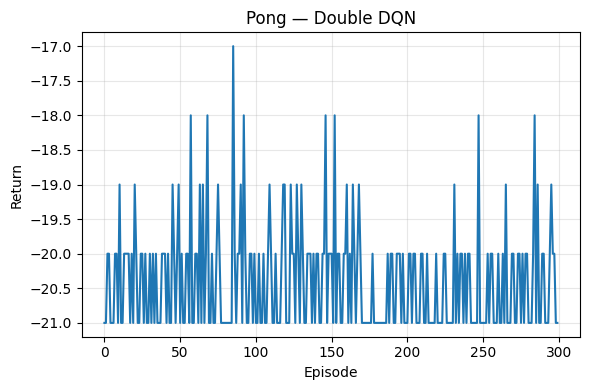

Videos: []
Checkpoints: ['ale_pong-v5_final.pt', 'ale_pong-v5_early.pt']


In [ ]:
def _ddqn_loss(batch, net, tgt_net, gamma=GAMMA):
    states_t, actions_t, rewards_t, dones_t, next_states_t = batch_to_tensors(batch, device)
    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_actions = net(next_states_t).argmax(dim=1)
        next_q = tgt_net(next_states_t).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        next_q = next_q.masked_fill(dones_t, 0.0)
        target = rewards_t + gamma * next_q
    return F.mse_loss(q_sa, target)

def train_and_record(max_episodes=300,
                     early_step_mark=50_000,
                     video_out="videos_ddqn",
                     ckpt_dir="checkpoints_ddqn",
                     max_steps_total=500_000):
    os.makedirs(video_out, exist_ok=True)
    os.makedirs(ckpt_dir, exist_ok=True)

    env = make_env(ENV_ID)
    obs, _ = env.reset(seed=SEED)
    arr = np.array(obs)
    if arr.ndim == 2:
        arr = arr[None, ...]
    elif arr.ndim == 3 and arr.shape[-1] == 1:
        arr = np.transpose(arr, (2, 0, 1))
    c, h, w = arr.shape
    n_actions = env.action_space.n

    policy_net = DQN((c, h, w), n_actions).to(device)
    target_net = DQN((c, h, w), n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer, epsilon=1.0, device=device)

    global_step, episode = 0, 0
    moving_returns = collections.deque(maxlen=100)
    episode_returns = []
    last_loss = None
    early_done = False

    def _safe_log(ep_idx, ep_ret, eps, step, loss_val=None, mov=None):
        if "writer" not in globals() or globals()["writer"] is None:
            return
        writer.add_scalar("train_pong_ddqn/return", ep_ret, ep_idx)
        writer.add_scalar("train_pong_ddqn/epsilon", eps, step)
        if loss_val is not None:
            writer.add_scalar("train_pong_ddqn/loss", loss_val, step)
        if mov is not None:
            writer.add_scalar("train_pong_ddqn/moving100", mov, step)
        writer.flush()

    while episode < max_episodes:
        if global_step >= max_steps_total:
            print("Stopping: hit step cap.")
            break

        agent.epsilon = epsilon_at_step(global_step)
        r = agent.play_step(policy_net)
        global_step += 1

        if len(buffer) >= REPLAY_START_SIZE:
            batch = buffer.sample(BATCH_SIZE)
            loss = _ddqn_loss(batch, policy_net, target_net, gamma=GAMMA)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
            optimizer.step()
            last_loss = loss

        if global_step % TARGET_SYNC_EVERY == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if (not early_done) and (global_step >= early_step_mark):
            ckpt = os.path.join(ckpt_dir, f"{ENV_ID.replace('/','_').lower()}_early.pt")
            torch.save({'step': global_step, 'model': policy_net.state_dict()}, ckpt)
            early_dir = os.path.join(video_out, f"{ENV_ID.replace('/','_').lower()}_early")
            try:
                record_episode(policy_net, ENV_ID, early_dir, epsilon=1.0, render_fps=60, video_seconds=18)
            except Exception as _e:
                print("early video skipped:", _e)
            early_done = True

        if r is not None:
            episode_returns.append(r)
            moving_returns.append(r)
            mv = float(np.mean(moving_returns)) if moving_returns else None
            _safe_log(episode, r, agent.epsilon, global_step,
                      loss_val=(last_loss.item() if last_loss is not None else None),
                      mov=mv)
            episode += 1

    final_ckpt = os.path.join(ckpt_dir, f"{ENV_ID.replace('/','_').lower()}_final.pt")
    torch.save({'step': global_step, 'model': policy_net.state_dict()}, final_ckpt)

    learned_dir = os.path.join(video_out, f"{ENV_ID.replace('/','_').lower()}_learned")
    try:
        record_episode(policy_net, ENV_ID, learned_dir, epsilon=0.0, render_fps=60, video_seconds=22)
    except Exception as _e:
        print("final video skipped:", _e)

    return {"final_step": global_step, "episodes": episode, "episode_returns": episode_returns}

# Run + export curve
results = train_and_record()
print("Finished. Results:", {k: (v if k != "episode_returns" else f"{len(v)} values") for k, v in results.items()})

import pandas as pd
os.makedirs('figures', exist_ok=True); os.makedirs('results', exist_ok=True)
curve = results.get('episode_returns', [])
df = pd.DataFrame({'episode': range(len(curve)), 'return': curve})
df.to_csv('results/pong_ddqn_returns.csv', index=False)
plt.figure(figsize=(6,4)); plt.plot(df['episode'], df['return'])
plt.xlabel('Episode'); plt.ylabel('Return'); plt.title('Pong — Double DQN'); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig('figures/pong_ddqn_curve.png', dpi=150); plt.show()

print('Videos:', os.listdir('videos_ddqn') if os.path.exists('videos_ddqn') else 'N/A')
print('Checkpoints:', os.listdir('checkpoints_ddqn') if os.path.exists('checkpoints_ddqn') else 'N/A')

## Smooth video recording function (60 FPS for early and learned gameplay)

In [ ]:
def record_episode(net, env_id: str, video_dir: str,
                   epsilon: float = 0.0,
                   max_steps: int = 4000,
                   render_fps: int = 60,
                   video_seconds: int = 20):

    import os, numpy as np, torch, gymnasium as gym
    import imageio

    os.makedirs(video_dir, exist_ok=True)
    max_frames = int(render_fps * video_seconds)

    env = gym.make(env_id, frameskip=1, repeat_action_probability=0.25, render_mode="rgb_array")
    env = AtariPreprocessing(env, grayscale_obs=True, frame_skip=1, scale_obs=False, screen_size=84)
    env = ToCHW(env)
    env = FrameStack(env, num_stack=4)

    state, _ = env.reset(seed=SEED)
    total_reward, steps, frames_written = 0.0, 0, 0

    out_path = os.path.join(video_dir, "pong-episode-0.mp4")
    writer = imageio.get_writer(out_path, fps=render_fps, macro_block_size=1)

    done = False
    while not done and steps < max_steps and frames_written < max_frames:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q = net(state_to_tensor(state, device))
                action = int(q.argmax(dim=1).item())

        state, r, term, trunc, _ = env.step(action)
        done = term or trunc
        total_reward += r
        steps += 1

        frame = env.render()  # (H,W,3) uint8 or None
        if frame is None:
            # fallback if a backend returns None this step
            frame = np.transpose(state[-1], (1, 2, 0))  # last grayscale frame -> (H,W,1)
            frame = np.repeat(frame, 3, axis=2).astype(np.uint8)
        writer.append_data(frame)
        frames_written += 1

    writer.close()
    env.close()
    print(f"Saved MP4: {out_path} | return={total_reward:.1f}, steps={steps}, frames={frames_written}/{max_frames}, fps={render_fps}")

## Rebuild the Net, Load Final Weights, Make Both Videos


In [ ]:
import os, torch, numpy as np

# Build env to infer shapes
env_tmp = make_env(ENV_ID)
state0, _ = env_tmp.reset(seed=SEED)
arr = np.array(state0)
if arr.ndim == 2:
    arr = arr[None, ...]
elif arr.ndim == 3 and arr.shape[-1] == 1:
    arr = np.transpose(arr, (2, 0, 1))
c, h, w = arr.shape
n_actions = env_tmp.action_space.n
env_tmp.close()

# Load model
policy_net = DQN((c, h, w), n_actions).to(device).eval()
ckpt_path = "checkpoints_ddqn/ale_pong-v5_final.pt"
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
ckpt = torch.load(ckpt_path, map_location=device)
policy_net.load_state_dict(ckpt["model"])

# Output folders
early_dir = "videos_ddqn/ale_pong-v5_early"
learned_dir = "videos_ddqn/ale_pong-v5_learned"

# Make videos
record_episode(policy_net, ENV_ID, early_dir,   epsilon=1.0, render_fps=60, video_seconds=18)
record_episode(policy_net, ENV_ID, learned_dir, epsilon=0.0, render_fps=60, video_seconds=22)

# List outputs
print("Videos:")
for d in [early_dir, learned_dir]:
    print(" ", d, "->", os.listdir(d) if os.path.exists(d) else "N/A")

Saved MP4: videos_ddqn/ale_pong-v5_early/pong-episode-0.mp4 | return=-2.0, steps=1080, frames=1080/1080, fps=60
Saved MP4: videos_ddqn/ale_pong-v5_learned/pong-episode-0.mp4 | return=-8.0, steps=1320, frames=1320/1320, fps=60
Videos:
  videos_ddqn/ale_pong-v5_early -> ['pong-episode-0.mp4']
  videos_ddqn/ale_pong-v5_learned -> ['pong-episode-0.mp4']
